In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import tifffile as tiff
from tensorflow.keras.utils import load_img, img_to_array

In [2]:
MODEL_TARGET = os.environ.get('MODEL_TARGET')
GCP_PROJECT = os.environ.get('GCP_PROJECT')
GCP_REGION = os.environ.get('GCP_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BQ_REGION = os.environ.get('BQ_REGION')
BQ_DATASET = os.environ.get('BQ_DATASET')
PLATE_NUMBER = os.environ.get('PLATE_NUMBER')

LOCAL_DATA_PATH = os.path.join(os.path.expanduser('~'), ".morpho_minds_data")

In [3]:
data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, PLATE_NUMBER, 'processed', f'{PLATE_NUMBER}_small.csv'))
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PhGolgi      2304 non-null   object 
 1   Hoechst      2304 non-null   object 
 2   ERSyto       2304 non-null   object 
 3   Mito         2304 non-null   object 
 4   ERSytoBleed  2304 non-null   object 
 5   CellCount    2304 non-null   int64  
 6   Well         2304 non-null   object 
 7   PhotoNumber  2304 non-null   int64  
 8   Role         2304 non-null   object 
 9   MMoles       2304 non-null   float64
 10  Plate        2304 non-null   int64  
 11  MeanArea     2304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 216.1+ KB


In [4]:
paths_df = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))

In [25]:
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

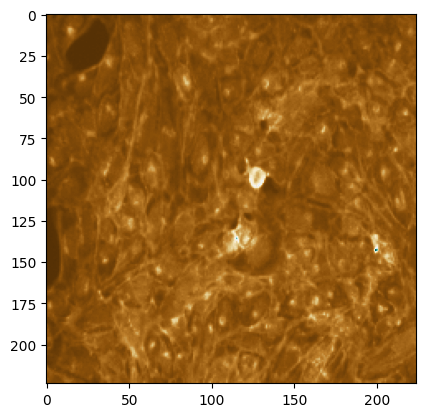

In [31]:
#images_batch/=65535
plt.imshow(images_batch[0, :, :, 0], cmap='BrBG')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

In [33]:
base_model_score = np.sum((data_df['CellCount'] - data_df['CellCount'].mean())**2)/data_df.shape[0]
base_model_score

771.4876030815972

In [34]:
def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

In [35]:
model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/100
41/41 [==============================] - 26s 593ms/step - loss: 2111.2537 - val_loss: 475.7352
Epoch 2/100
41/41 [==============================] - 24s 596ms/step - loss: 329.9251 - val_loss: 268.4872
Epoch 3/100
41/41 [==============================] - 23s 557ms/step - loss: 258.8506 - val_loss: 305.0244
Epoch 4/100
41/41 [==============================] - 23s 558ms/step - loss: 305.5193 - val_loss: 247.6172
Epoch 5/100
41/41 [==============================] - 26s 646ms/step - loss: 211.5432 - val_loss: 236.2696
Epoch 6/100
41/41 [==============================] - 27s 649ms/step - loss: 180.4782 - val_loss: 215.0786
Epoch 7/100
41/41 [==============================] - 24s 576ms/step - loss: 149.2499 - val_loss: 223.4454
Epoch 8/100
41/41 [==============================] - 23s 549ms/step - loss: 166.2702 - val_loss: 238.7088
Epoch 9/100
41/41 [==============================] - 23s 551ms/step - loss: 164.0302 - val_loss: 208.9904
Epoch 10/100
41/41 [=========================

In [36]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 2s 106ms/step - loss: 209.6734


209.67343139648438

1640    124
508      68
1422    111
44      231
1398    134
       ... 
1825    108
1674    132
1813    122
1776    135
2227    101
Name: CellCount, Length: 461, dtype: int64

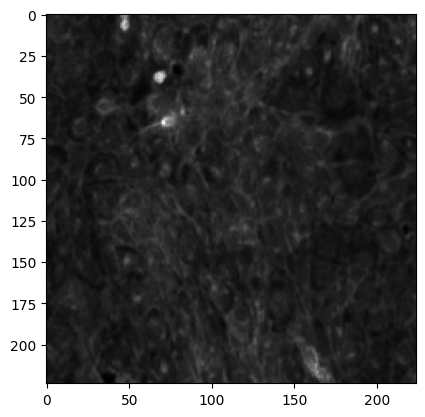

In [45]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [47]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 177ms/step


array([[127.36771]], dtype=float32)

In [49]:
paths_df = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 22s 531ms/step - loss: 2486.8242 - val_loss: 400.6823
Epoch 2/100
41/41 [==============================] - 22s 548ms/step - loss: 295.5010 - val_loss: 246.2793
Epoch 3/100
41/41 [==============================] - 23s 557ms/step - loss: 206.0064 - val_loss: 174.3896
Epoch 4/100
41/41 [==============================] - 23s 570ms/step - loss: 152.7602 - val_loss: 122.2195
Epoch 5/100
41/41 [==============================] - 23s 563ms/step - loss: 106.9774 - val_loss: 88.3748
Epoch 6/100
41/41 [==============================] - 23s 557ms/step - loss: 83.7852 - val_loss: 88.0936
Epoch 7/100
41/41 [==============================] - 23s 564ms/step - loss: 69.3428 - val_loss: 133.2310
Epoch 8/100
41/41 [==============================] - 24s 592ms/step - loss: 63.3527 - val_loss: 97.3814
Epoch 9/100
41/41 [==============================] - 23s 571ms/step - loss: 46.1638 - val_loss: 88.9212
Epoch 10/100
41/41 [==============================] -

In [53]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 2s 113ms/step - loss: 81.5905


81.59053802490234

In [52]:
model.predict(X_test[1].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 46ms/step


array([[63.7808]], dtype=float32)

In [51]:
y_test

1640    124
508      68
1422    111
44      231
1398    134
       ... 
1825    108
1674    132
1813    122
1776    135
2227    101
Name: CellCount, Length: 461, dtype: int64

In [56]:
paths_df = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 23s 549ms/step - loss: 741.9147 - val_loss: 225.2744
Epoch 2/100
41/41 [==============================] - 23s 563ms/step - loss: 248.6852 - val_loss: 166.7384
Epoch 3/100
41/41 [==============================] - 24s 588ms/step - loss: 276.1290 - val_loss: 149.8790
Epoch 4/100
41/41 [==============================] - 22s 543ms/step - loss: 139.1293 - val_loss: 109.2622
Epoch 5/100
41/41 [==============================] - 23s 567ms/step - loss: 95.8503 - val_loss: 281.2077
Epoch 6/100
41/41 [==============================] - 23s 568ms/step - loss: 100.4147 - val_loss: 109.1030
Epoch 7/100
41/41 [==============================] - 23s 552ms/step - loss: 63.1928 - val_loss: 65.2231
Epoch 8/100
41/41 [==============================] - 23s 552ms/step - loss: 48.3084 - val_loss: 131.3165
Epoch 9/100
41/41 [==============================] - 24s 581ms/step - loss: 51.5160 - val_loss: 66.9916
Epoch 10/100
33/41 [=======================>......] 